## OOP  & Simple models for ice break up
An effective way to create and use python model is by using and Object Oriented Programming approach, in our case we will use the class `IceModel` to construct different models by instancing an object of the class.

In part 1 of this interactive textbook you familiarized yourself with the **Nenana Ice Classic**, got introduce to a new data structure,`DataFrames`, explore  variables that may help to predict the break up, and learned some basic preprocessing techniques.

In [1]:
import pandas as pd
import numpy as np
from datetime import time ,datetime,timedelta
from scipy import stats
import matplotlib.pyplot as plt

def decimal_time(t, direction='to_decimal'):
    """ Convert time object to decimal and decimal to time object depending on the direction given

    Arguments:
        t : datetime object if `direction is 'to_decimal'`
            float if `direction='to_hexadecimal'`
    Returns:
        float if direction is 'to_decimal'
        datetime object if direction is 'to_hexadecimal'
    """

    if direction =='to_decimal':
        return t.hour+t.minute/60
    elif direction=='to_hexadecimal':
        hours=int(t)
        minutes=int((t-hours)*60)
        return time(hours,minutes)
    else:
        raise ValueError("Invalid direction, choose 'to_decimal'or 'to_hexadecimal'")
    

class IceModel(object):

    """
    Simple model that fits trend to historic data to extrapolate future break up date.

    Only considers previous break up dates. 


    The model compute the date and day separately

    METHODS:
        polyfit: Polinomic fit
        distfit: Fits distributions
        predict: Predicts the value of a variable based on the fit/dist
        get_prediction: Calles predict to get date and time
    """

    def __init__(self, df_dates:pd.DataFrame, df_variables=None):
        """
        Initializing object with DataFrame with break up dates.
        
        Arguments:
        ----------

        df_dates: pandas DataFrame
            DataFrame with break up dates.
        df_variables:pandas DataFrame, optional):
            DataFrame with additional variables. Defaults to None.
        """
        self._df_dates = df_dates.copy()
        self.df_variables = df_variables.copy() if df_variables is not None else pd.DataFrame()
        self._predicted_day_of_break_up = None  
        self._predicted_time_of_break_up = None
        
        # Initialize created properties tracker
        self._created_properties = set()

        # Dynamically create properties for each column in df_variables
        if not self.df_variables.empty:
            for column in self.df_variables.columns:
                self._create_property(column, self.df_variables[column])
    
    def _create_property(self, name, data):
        """Creates a property with a getter and setter for a given data Series or DataFrame column.
        
        Args:
            name (str): Name of the property.
            data (pandas Series): Data to be used for the property.
        """
        if len(data) != len(self._df_dates):
            raise ValueError("The length of the data must match the length of df_dates.")
        
        private_name = '_' + name

        setattr(self, private_name, data)
        
        def getter(self):
            return getattr(self, private_name)
        
        def setter(self, value):
            if len(value) != len(self._df_dates):
                raise ValueError("The length of the value must match the length of df_dates.")
            setattr(self, private_name, value)
        
        setattr(self.__class__, name, property(fget=getter, fset=setter))
        self._created_properties.add(name)

    def add_property(self, series, name_prop='new_property'):
        """Adds a new property to the class based on the provided Series.
        
        Args:
            series (pandas Series): Series to be added as a property.
            name_prop (str): Name of the new property.
        """
        if not isinstance(series, pd.Series):
            raise TypeError("The argument must be a pandas Series.")
        if len(series) != len(self._df_dates):
            raise ValueError("The length of the series must match the length of df_dates.")
        if name_prop in self._created_properties:
            raise ValueError(f"Property '{name_prop}' already exists.")
        
        self._create_property(name_prop, series)
    
    def get_created_properties(self):
        """Returns a list of the properties dynamically created for the class."""
        return list(self._created_properties)

#=======================================================================================================
# Properties and methods related to df_dates 
#======================================================================================================
# DF without datetime index, each column correspond to break up dates in different format
# we can add more columns to this df but is important to understand that this df constaining one value per year
    
    # ------------------------------#
    # Properties basics
    # ------------------------------#
    @property
    def date_time(self):
        return  pd.to_datetime(self._df_dates[['Year', 'Month', 'Day', 'Hour', 'Minute']])
    
    @property
    def time(self):
        return self.date_time.dt.time
    @property
    def decimal_time(self):
        return self.time.apply(lambda t: decimal_time(t,direction='to_decimal'))
   
    @property
    def day_of_year(self):
        return self.date_time.dt.dayofyear.tolist()
   
    @property
    def year(self):
        return self.date_time.dt.year
     
    # ------------------------------#
    # Properties associated with Fits
    # ------------------------------#
    @property
    def fit_time(self):
        return self.fit_time
    
    @fit_time.setter
    def fit_time(self,value):   # revisar con test
        self.fit_time=value
    
    @property
    def fit_day_of_year(self):
        return self.fit_day_of_year
    @fit_day_of_year.setter
    def fit_day_of_year(self,value):
        self.fit_day_of_year=value
   
 
    # ------------------------------#
   # Properties to get predicted values
    # ------------------------------#
    @property
    def predicted_day_of_break_up(self,year=None):
        if self.predicted_day_of_break_up is None:
            raise ValueError(" Predicton of day of break up has not been made")
        return self.get_predicted_day(year)
    
    @predicted_day_of_break_up.setter
    def predicted_day_of_break_up(self,value):
        self._predicted_day_of_break_up=value
    
    @property
    def predicted_time_of_break_up(self):
        if self.predicted_time_of_break_up is None:
            raise ValueError(" Predicton of time of break up has not been made")
        return self.get_predicted_time
    @predicted_time_of_break_up.setter
    def predicted_dtime_of_break_up(self,value):
        self._predicted_time_of_break_up=value
   
    @property
    def prediction(self):
        if self._prediction is None:
            raise ValueError(" Predicton of  date and time of break up has not been made")
        return self.get_prediction
    @prediction.setter
    def prediction(self,value):
        self._prediction=value

   
     
    # ------------------------------#       
    # methods
    # ------------------------------#
    def polyfit(self,x_property: str ,y_property: str,degree: int=1,norm_order: int=2,print_eq:bool=True,plot:bool=False):
        """ 
        Fits polynomial function to properties of object

        The name of the property to use as 'x'  and  'y' must exist and be of the same length. The fit is saved as an attribute of the class 

        Parameters
        ---------- 
        x_property: str
            name of the property to use as 'x' in fit.
        y_property : str
             name of property to use as 'y' in fit
        degree : int
            degree of polynomial
        norm: int 
             degree of norm used to compute residuals, Default=2 
        print_eq: bool
            Determines if the equation of the fitted polynomial is printed
        plot: bool
            Determines if the plot of the data and the fitted polynomial is shown
    
        Returns
        ----------
        dict : dictionary with the fitted polynomial, name of the variables use for the fit and goodness of fit metrics. 
        """


        x=getattr(self,x_property)
        if y_property =='time':  # we want to use decimal time for the fit
            y_property='decimal_time'
        y=getattr(self,y_property)

        #print(x,y)

        coefs=np.polyfit(x,y,degree)

        
        polynomial=np.poly1d(coefs)
        
        if print_eq:
            print(polynomial)
            
        # G0odness of fit
        y_predict=polynomial(x)
        residuals=y-y_predict
        norm=np.linalg.norm(residuals,norm_order)  

        # these metrics are not generalized for higher order norms, they simply are the traditional metrics
        ss_res=np.sum(residuals**2)
        ss_tot=np.sum((y-np.mean(y))**2)

        r2=1-(ss_res/ss_tot)

        rmse=np.sqrt(np.mean((y-y_predict)**2))
        nrmse=rmse/(np.max(y)-np.min(y))

        n=len(y)  # number of points
        k=degree # how many coef are we estimating
        R2=1-((1-r2)*(n-1))/(n-k-1)
        
        gofs={f'{norm_order:}th norm':round(norm,4),'r2':round(r2,4),'R2':round(R2,4),'RMSE':round(rmse,4),'normalized RMSE':round(nrmse,4)}

        setattr(IceModel,'fit_'+str(y_property),{'Poly fit coefficients':polynomial,'(x,y)=':[x_property,y_property],'gofs metrics':gofs})

        if plot:
            plt.scatter(x, y, color='blue',alpha=0.5)
            x_ = np.linspace(min(x), max(x), 100)
            y_ = polynomial(x_)
        
            plt.plot(x_, y_, color='red', linestyle='--',linewidth=2)

            plt.xlabel(x_property)
            plt.ylabel(y_property)
            plt.title(f'Polynomial Fit degree={degree}')
            plt.grid(True)
            plt.show()

       # return {'Poly fit coefficients':polynomial,'(x,y)=':[x_property,y_property],'gofs metrics':gofs}
    
    def predict(self, variable: str, new_x) -> dict:
        """
        Uses the polynomic fit or distribution fit  associated with the y_property to predict y based on new value of x.

        Parameters
        ----------
        Variable: str
            Name of the property to check (e.g., 'decimal_time' for polynomial fit, etc.)
        new_x: float
            Value of x use to predict y.
        
        Returns
        ----------
        dict: A dictionary with information about the prediction:
            - (x,y): Tuple of the x and y properties used for fitting.
            - x_hat: The new x value used for prediction.
            - y_hat: The predicted y value.
            - confidence_interval: The confidence interval for the prediction (only for distributions).
        """

        if not self.check_property(variable):
            raise AttributeError(f"Variable '{variable}' is not part of the predicted variables")
        
        fit = getattr(self, 'fit_' + str(variable))
    
        if 'Poly fit coefficients' in fit:
            # Polynomial fit
            fit_coefs = fit['Poly fit coefficients']
            predicted_y = fit_coefs(new_x)
            return {
                '(x,y)': fit['(x,y)='],
                'x_hat': new_x,
                'y_hat': round(predicted_y, 4)
            }
        
        elif 'Fitted Distribution' in fit:
            # Distribution fit
            distribution = fit['Fitted Distribution']
            params = fit['Parameters']
            dist = getattr(stats, distribution)

            # Compute the predicted value (expected value of distribution)
            predicted_y = dist(*params).mean()

            # Confidence interval
            if distribution == 'norm':
                ci =  1.96* dist(*params).std() 
                lower_bound = predicted_y - ci
                upper_bound = predicted_y + ci
                confidence_interval = (round(lower_bound, 4), round(upper_bound, 4))
            else:
                confidence_interval = 'N/A'  # finish this

            return {
                '(x,y)': fit['(x,y)='],
                'x_hat': new_x,
                'y_hat': round(predicted_y, 4)
            }
        
        else:
            raise AttributeError(f"No fit found for variable '{variable}'")
    
    def check_property(self,prop_name):
        """
        simple method that check if a fit corresponding to that variable exists
        """
        if not hasattr(self,prop_name):
            raise AttributeError(f'variable "{prop_name}" not part of the model')
        else: 
            return True
        
    def get_prediction(self,x_vars)->datetime:
        """
         Calls the function to predict the date (day of year) and time of break up
         

        Parameters
        ----------
        xvars: list
            List with the x variables that will be use to predict with date and time (respectably).

        Notes
        ----------
            The method is not generalized for other properties, it is only for date and time. For predicting other properties,
                it is necessary to use .predict() which can receive any two existing properties.
            A list of x_vars is required instead of a single value, as in other future complex model, the predicted date/time could correspond 
                to a combination of variables for different years.

        Returns
        ----------
        datetime: The predicted date and time of break up
        """
    
            # we are re-getting  the value just to make sure they correspond to the latest assigned fits

        #DATE
        x_fit_date=x_vars[0]
        day=self.predict('day_of_year', x_fit_date)
        date=datetime(x_fit_date,1,1)+timedelta(days=int(day['y_hat'])-1)
        
        #TIME
        x_fit_time=x_vars[1]
        time=decimal_time(self.predict('decimal_time',x_fit_time)['y_hat'],direction='to_hexadecimal')
        #Combine
        self._prediction=datetime.combine(date,time)
        print(self._prediction)

    def dist_fit(self, x_property: str, y_property: str, distribution: str = 'norm', print_eq: bool = True,ci=1.96,plot=False): 
        """ Fit a distribution to properties of the object

        Args:
            x_property (str): Name of the x property (not used in this implementation but kept for consistency)
            y_property (str): Name of the y property
            distribution (str): Name of the distribution to fit (from scipy.stats). Default is 'norm'.
                                'norm' for normal distribution
                                'expon' for exponential distribution
                                'gamma' for gamma distribution
                                'lognorm' for lognormal distribution
                                'weibull_min' for Weibull distribution
                                'weibull_max' for Frechet distribution
                                'pareto' for Pareto distribution
                                'genextreme' for Generalized Extreme Value distribution
                                'gumbel_r' for Gumbel Right (minimum) distributionE
                                ...
            plot (bool): Determines if a histogram of the data and the fitted distribution are plotted. Default is False.   
            print_eq (bool): Determines if the equation of the fitted distribution is printed. Default is True.
            ci (float): Confidence interval for the prediction. Default is 1.96 (95% CI). generalize this for other distributions

        Prints:
            Parameters of the fitted distribution and goodness-of-fit metrics.

        Returns:
            dict: Dictionary with fitted distribution, names of the variables used for the fit, and goodness-of-fit metrics.
        """

        
        if not hasattr(self, x_property):
            print(f"Property '{x_property}' not found .")
            return {}

        if y_property == 'time':  # Convert 'time' to 'decimal_time' if needed
            y_property = 'decimal_time'

        if not hasattr(self, y_property):
            print(f"Property '{y_property}' not found in the object.")
            return {}

        x = getattr(self, x_property)
        y = getattr(self, y_property)


        # Check if the distribution is valid (could take out as itis mention in description)
        if not hasattr(stats, distribution):
            print(f"Distribution '{distribution}' not found in scipy.stats.")
            return {}

        dist = getattr(stats, distribution)
        
        # Fit the distribution
        params = dist.fit(y)
        fitted_dist = dist(*params)

        # Goodness-of-fit metrics
        ks_stat, ks_p_value = stats.kstest(y, fitted_dist.cdf)
        
        gofs = {
            'KS Statistic': round(ks_stat, 4),
            'KS p-value': round(ks_p_value, 4),
        }

        if print_eq:
            print(f"Distribution: {distribution}")
            print(f"Parameters: {params}")

        results = {
            'Fitted Distribution': distribution,
            'Parameters': np.round(params,4),
            '(x,y)=': [x_property, y_property],
            'Goodness-of-Fit Metrics': gofs
        }
        if plot:
            # Histogram of the data
            plt.hist(y, density=True, alpha=0.6, color='g')

            # Plot the PDF of the fitted distribution
            xmin, xmax = min(y), max(y)
            x = np.linspace(xmin, xmax, 100)
            p = fitted_dist.pdf(x)
            plt.plot(x, p, 'k', linewidth=2, label=f'{distribution} fit')

            plt.xlabel(y_property)
            plt.ylabel('Density')
            plt.title(f'Histogram of {y_property} with Fitted {distribution} distribution')
            plt.legend()
            plt.grid(True)
            plt.show()

        setattr(self, 'fit_' + str(y_property), results)
#=======================================================================================================
# Properties related to df_dates 
#======================================================================================================
   # dynamically create when the object is created
#======================================================================================================
#======================================================================================================
#======================================================================================================
        return results

In [2]:
import pprint
import matplotlib.pyplot as plt 
# loading the fil
ice_data = pd.read_csv('../../data/BreakUpTimes.csv')

#### Basic Usage
The first step to our simple OOP ice break model is to create an instance of the class.

In [3]:
Model_1=IceModel(ice_data)

The class has a number of properties and very simple methods that can be use to predict the ice break up, 
When creating the object, the following properties are created:

- `.date_time` :  pd.Series with the  *datetime* of break up dates 
- `.time` : pd.Series with the *time*
- `.decimal_time`: pd.Series with the *decimal time*  
- `.year`: pd.Series with the *years* 
- `day_of_year`: pd.Series with the *day_of_year* (day since jan of the corresponding year)

And the following methods
- `.polyfit()`: Fits a polynomial equation to the data
- `.distfit()` : Fits a distribution to the data
- `.predict()`: Uses the fits to predict a variable
- `.get_prediction():`: Get the predicted date and time.  



#### Prediction using `.polyfit()`
The class assumes that the  **date** and **time** of break up independent of each other, and therefore it predicts them separately. 

Lets start by using `.polyfit()` to predict the **day** of break up for the year 2025 using a simple linear regression. 

           2
-0.000744 x + 2.852 x - 2606


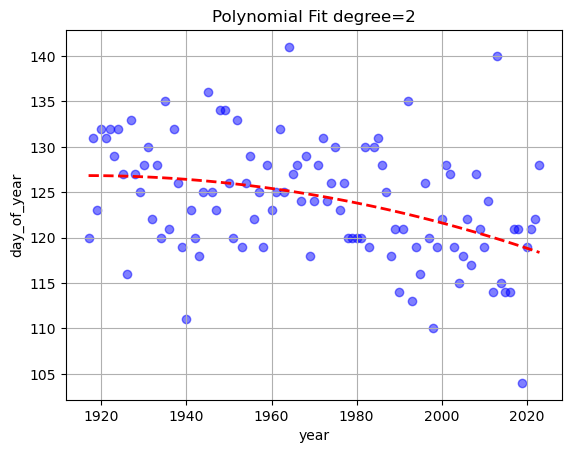

In [4]:
date_fit=Model_1.polyfit('year','day_of_year',plot=True,degree=2)  

The result of the linear regression is 
$$\text{dayofyear}=-0.07984*\text{year}+281.3$$

Meaning that the break-up date seems to be happening earlier each year. What could be the cause of this ? 


The details of the *fit* are stored in an attribute called `.fit_*y_property*`, in this particular case on `Model_1.fit_day_of_year`.

In [5]:
pprint.pprint(Model_1.fit_day_of_year)

{'(x,y)=': ['year', 'day_of_year'],
 'Poly fit coefficients': poly1d([-7.44040798e-04,  2.85167984e+00, -2.60557023e+03]),
 'gofs metrics': {'2th norm': 61.3526,
                  'R2': 0.1394,
                  'RMSE': 5.9312,
                  'normalized RMSE': 0.1603,
                  'r2': 0.1556}}


The method `.predict()` uses the polynomial fit associated with that property to predict the new value.  

In [6]:
fitted_date=Model_1.predict('day_of_year', 2025)                            
print(fitted_date)

{'(x,y)': ['year', 'day_of_year'], 'x_hat': 2025, 'y_hat': 118.0492}


Similarly, for the  break up **time**.

 
0.01105 x - 7.39


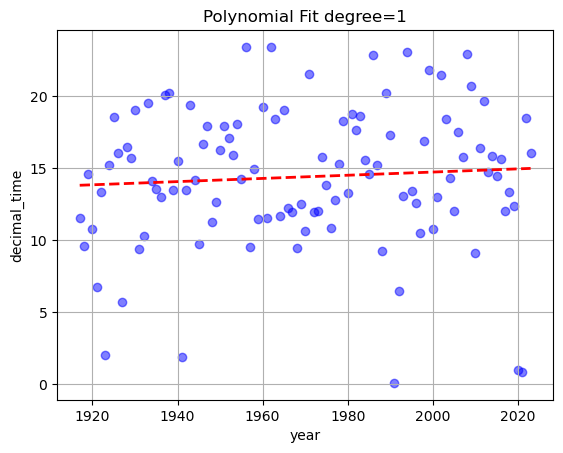

{'(x,y)': ['year', 'decimal_time'], 'x_hat': 2025, 'y_hat': 14.9863}


In [7]:
Model_1.polyfit('year','time',plot=True)                                            
fitted_time=Model_1.predict('decimal_time',2025)                           
print(fitted_time) 

You may have noticed that in the case of the predicted time, we need to use the property 'decimal time'. The conversion is handled internally by the function `decimal_time()`, which simply convert the minutes to a fraction of the hour in the following manner:

$$ 18:30 \equiv 18.5$$

Naturally, the predicted break-up **time** will also be in 'decimal time'.

However, if the fits associated with **time** and **date** have been created , we can directly use the  method `get_prediction()`, which calls internally  `.predict()` to predict the time and date, and then it combines them into a single formatted prediction (YYYY-MM-DD HH:mm:ss). 


In [8]:
Model_1.get_prediction([2025,2025])


2025-04-28 14:59:00


We can easily change the year we want to predict by simply passing another year

In [9]:
Model_1.get_prediction([2030,2030])

2030-04-27 15:02:00


We can easily change the fit associated withe either *date* or *time* to get a different prediction.

For example we could predict the **date** for a specific year, then predict the **time** using a fit generated by the relationship between  the **dayofyear** of the break up and the **time** of break up 

> for this to make sense the date needs to be predicted first as this result is used in the prediction of the time (therefore the date and time are not independent anymore)


 
-0.07006 x + 23.06


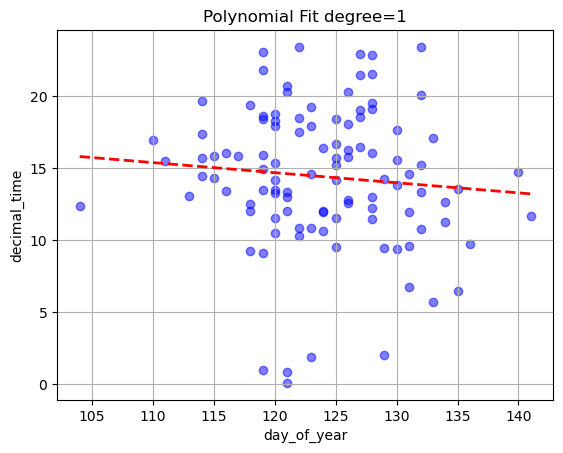

2030-04-27 14:43:00


In [10]:
time_fit_2=Model_1.polyfit('day_of_year','time',plot=True) 
day_of_year_2025=pd.to_datetime('2025-04-29').dayofyear
Model_1.get_prediction([2030,day_of_year_2025])

#### Prediction using `.dist_fit()` 

The method `.dist_fit()` is similar to `.polyfit()`, but instead of fitting a polynomial to the data, it fits a distribution to the data.
For example, lets fit a normal distribution

Distribution: norm
Parameters: (123.98130841121495, 6.454703868217181)


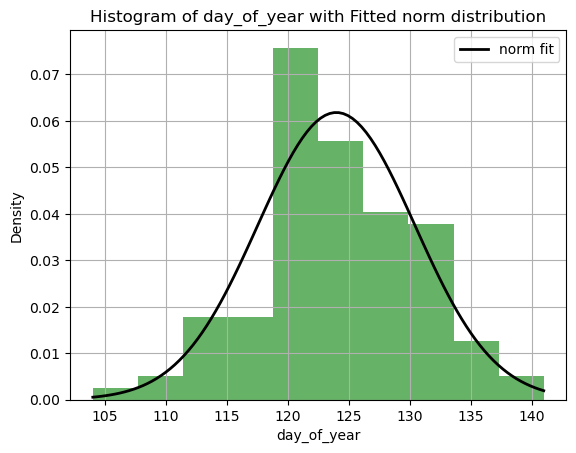

In [11]:
date_fit=Model_1.dist_fit('year','day_of_year',distribution='norm',plot=True)         

The detail fo the fitted distribution are stored in the same way

In [12]:
pprint.pprint(date_fit)

{'(x,y)=': ['year', 'day_of_year'],
 'Fitted Distribution': 'norm',
 'Goodness-of-Fit Metrics': {'KS Statistic': 0.0704, 'KS p-value': 0.6372},
 'Parameters': array([123.9813,   6.4547])}


The method `predict()` return the expected value of the fitted distribution as a prediction. 

> implment .cdf .pdf interval of confidence for break up. 


In [13]:
fitted_date=Model_1.predict('day_of_year', 2030)                            
print(fitted_date)

{'(x,y)': ['year', 'day_of_year'], 'x_hat': 2030, 'y_hat': 123.9813}


Distribution: norm
Parameters: (14.378504672897197, 4.834644794331982)


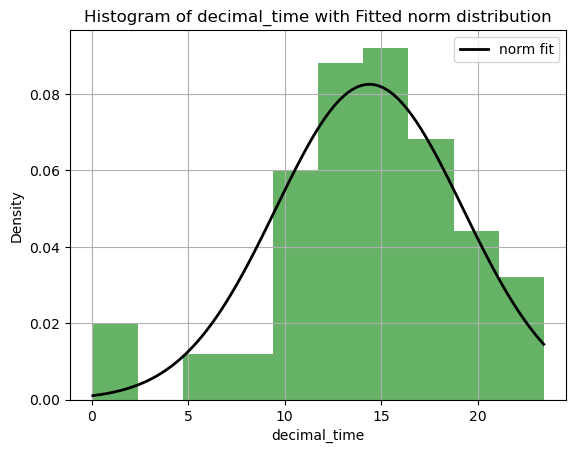

{'(x,y)': ['year', 'decimal_time'], 'x_hat': 2025, 'y_hat': 14.3785}


In [14]:
time_fit=Model_1.dist_fit('year','time',plot=True)                                            
fitted_time=Model_1.predict('decimal_time',2025)                           
print(fitted_time)

In [15]:
Model_1.get_prediction([2025,2025])


2025-05-03 14:22:00


###   More complex models
The models than can be constructed with the attributes and methods above are relatively limited as the variables/properties that the model can use/access are limited to a list with break up dates

We can improve on the class by adding  a method  called  `.add_property()`, which  receive a `Series` of the same lengths as `BreakUpTimes` and creates a corresponding property.



Let's use what we learned in the first about working with `DataFrames` and add a property with the max ice thickness in that year.

In [16]:
Model_1.year

0      1917
1      1918
2      1919
3      1920
4      1921
       ... 
102    2019
103    2020
104    2021
105    2022
106    2023
Length: 107, dtype: int32

In [17]:

df_data=pd.read_csv("../../data/Time_series_DATA.txt",skiprows=149,index_col=0,sep='\t')
df_data.index = pd.to_datetime(df_data.index, format="%Y-%m-%d")

df_cleaned = df_data[(df_data.index.year >= 1917) & (df_data.index.year < 2024)]  # we are only interested in the years that are in the break up data

max_ice_thickness = df_cleaned.groupby(df_cleaned.index.year)['IceThickness [cm]'].max()

Model_1.add_property(max_ice_thickness,'max_ice_thickness')

Model_1.max_ice_thickness


1917        NaN
1918        NaN
1919        NaN
1920        NaN
1921        NaN
         ...   
2019     82.550
2020     90.170
2021    117.348
2022     82.296
2023     82.042
Name: IceThickness [cm], Length: 107, dtype: float64

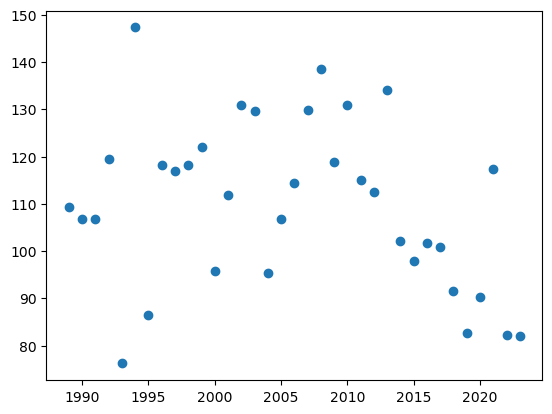

In [18]:
plt.scatter(Model_1.year,Model_1.max_ice_thickness)

As you can see it is very convenient to use the methods`grouby/tranform/apply` to extract a series with the same length of `BreakUpTimes`base on some specifies criteria. We could consider multiple properties to add such as 'last_measured_ice_thickness', 'last ice growth gradient` ,etc. 

So keep track of the properties that we have created we could use `dir(Object)` but it outputs more information than necessary, instead we can use the method `get_created_properties` to keep track of all the properties that we have created

In [20]:
Model_1.get_created_properties()

['max_ice_thickness']